# Prereading study storyline
## Loading the data

In [40]:
%matplotlib inline
import scipy
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
import numpy as np
import sys
import getpass
import math

In [41]:
# from scipy import stats 
dfraw = pd.read_csv('C:\Users\\'+getpass.getuser()+'\Desktop\Clean-data_160217_JBS_cleaned_051316.csv')
dfsurvey = pd.read_csv('C:\Users\\'+getpass.getuser()+'\Desktop\Clean-data_addSurvey_160309_JBS_cleaned_051316.csv')
#please read this about unicode strings eventually: http://www.joelonsoftware.com/articles/Unicode.html


# Klugetastic: make a list, convert to an array and then a df
datalist = []
#header = df.keys()
topics = ['Blackbody','Masses','Resonance']
treatments = ['TextThenPhet','TextOnly','PhetThenText']


#merge with main dataframe
dfmerged = pd.merge(left=dfraw,right=dfsurvey, left_on='anon-id', right_on='anon-id')

phetquestion = {'Blackbody':'q01 - Approximately how long did you spend with the PhET simulation? (in minutes)',
                'Masses':'q5 - Approximately how long did you spend with the PhET simulation? (in minutes)',
                'Resonance':'q6 - Approximately how long did you spend with the PhET simulation? (in minutes)'}
textquestion = {'Blackbody':'q02 - Approximately how long did you spend reading the textbook sections? (in minutes)',
                'Masses':'q6 - Approximately how long did you spend reading the textbook sections? (in minutes)',
                'Resonance':'q7 - Approximately how long did you spend reading the textbook sections? (in minutes)'}

conv_pos = {'nan':np.nan, 'Not at all':0.0, 'Somewhat':1.0, 'Mostly':2.0, 'Definitely':3.0}
conv_neg = {'nan':np.nan, 'Not at all':3.0, 'Somewhat':2.0, 'Mostly':1.0, 'Definitely':0.0}

encountered_question = {'Blackbody':'q03 -  Have you learned about blackbody radiation before? (Choose all that apply.)',
                        'Masses':'q7 - Have you learned about simple harmonic motion before? (Choose all that apply.)',
                        'Resonance':'q8 - Have you learned about resonance before? (Choose all that apply.)'}

def transform_encountered(response):
    response = str(response)
    if response == 'No.':
        return False
    if 'Yes' in response:
        return True
    else: 
        return np.nan

def lickert_convert(response):
    return float(conv_neg[str(response).split('<')[0]])

def compute_survey(responses):
    NAs = 0
    newresponses = []
    for s in responses:
        if s != np.nan:
            newresponses.append(s)
    return sum(newresponses)/len(newresponses)

#now we iterate through the dataframe and creat a row per student x topic
for index, row in dfmerged.iterrows():
    for topic in topics:
        #print row['q5 - For me personally; PhET Sims are usually useless.']
#         calculated_survey = compute_survey([lickert_convert(row['q2 - For me personally; PhET Sims are usually boring.']),
#                     lickert_convert(row['q5 - For me personally; PhET Sims are usually useless.']),
#                     lickert_convert(row['q4 - For me personally; PhET Sims are usually fun.']),
#                     lickert_convert(row['q3 - For me personally; PhET Sims are usually productive.'])])
        datalist.append([str(row['anon-id']),
                        str(row["Reading group_x"]),
                        float(str(row['PreScore.'+topic]).replace('%',''))/100.0,
                        topic,
                        row['Treatment.'+topic+'_x'],
                        float(str(row['PostScore.'+topic]).replace('%',''))/100.0,
                        float(str(row['ClickerScore.'+topic]).replace('%',''))/100.0,
                        row[textquestion[topic]],
                        row[phetquestion[topic]],
#                         calculated_survey,
                        row['q9 - How beneficial was this assignment to your learning?'],
                        row['q10 - How much did you enjoy this assignment?'],
                        transform_encountered(row[encountered_question[topic]])
                        ])

# convert list2 to an array then a dataframe
array2 = np.array(datalist)
colnames = ['student id',"Reading group",'Prescore','Topic','Treatment',
            'Postscore','Clickerscore','Time on text','Time on PhET',
#             'Preattitude',
            'Postattitude - benefitted','Postattitude - enjoyed','Encountered']
df = pd.DataFrame(array2,columns=colnames)

# Organizing the dataframe
#### Now that we have our data frame we can see what it looks like:

In [42]:
df.head()

,student id,Reading group,Prescore,Topic,Treatment,Postscore,Clickerscore,Time on text,Time on PhET,Postattitude - benefitted,Postattitude - enjoyed,Encountered
0,5963,3,nan,Blackbody,TextOnly,1.0,0.67,nan,nan,Not very beneficial.,Somewhat enjoyed it.,nan
1,5963,3,nan,Masses,TextThenPhet,1.0,1.0,25.0,7.0,Not very beneficial.,Somewhat enjoyed it.,True
2,5963,3,nan,Resonance,PhetThenText,0.67,0.33,20.0,6.0,Not very beneficial.,Somewhat enjoyed it.,True
3,25630,1,0.33,Blackbody,PhetThenText,0.67,0.67,nan,nan,Somewhat beneficial.,Somewhat enjoyed it.,nan
4,25630,1,0.0,Masses,TextOnly,0.0,0.75,20.0,0.0,Somewhat beneficial.,Somewhat enjoyed it.,True


#### First we want to make sure that the columns containing numerical data are treated as such. Let's also collapse the post attitude columns

In [43]:
#converting columns to numerical types
for column in ['Prescore','Postscore','Clickerscore', 'Time on text','Time on PhET']:
    df[column] = pd.to_numeric(df[column],errors='coerce')
df = df.fillna(np.nan)

def transform_enjoy(response):
    response = str(response)
    if 'No' in response or 'not' in response:
        return False
    elif 'enjoy' in response: 
        return True
    else: return np.nan
    
def transform_benefit(response):
    response = str(response)
    if 'Not' in response:
        return False
    elif 'beneficial' in response: 
        return True
    else: return np.nan
    
df['Benefitted'] = df['Postattitude - benefitted'].apply(transform_benefit)
df['Enjoyed'] = df['Postattitude - enjoyed'].apply(transform_enjoy)
df.head()

,student id,Reading group,Prescore,Topic,Treatment,Postscore,Clickerscore,Time on text,Time on PhET,Postattitude - benefitted,Postattitude - enjoyed,Encountered,Benefitted,Enjoyed
0,5963,3,NaN,Blackbody,TextOnly,1.00,0.67,NaN,NaN,Not very beneficial.,Somewhat enjoyed it.,nan,False,True
1,5963,3,NaN,Masses,TextThenPhet,1.00,1.00,25.0,7.0,Not very beneficial.,Somewhat enjoyed it.,True,False,True
2,5963,3,NaN,Resonance,PhetThenText,0.67,0.33,20.0,6.0,Not very beneficial.,Somewhat enjoyed it.,True,False,True
3,25630,1,0.33,Blackbody,PhetThenText,0.67,0.67,NaN,NaN,Somewhat beneficial.,Somewhat enjoyed it.,nan,True,True
4,25630,1,0.00,Masses,TextOnly,0.00,0.75,20.0,0.0,Somewhat beneficial.,Somewhat enjoyed it.,True,True,True


Unfortunately we have a lot of rows with missing data. If we remove them, we end up with almost half the dataset. We will use this dataset when looking at engagement.

In [73]:
df2 = df.dropna()
df_score1 = df[['Prescore','Postscore','Topic','Clickerscore','Treatment']]
df_score = df_score1.dropna()
df_score.shape
df2.shape, df.shape, df_score.shape

((531, 15), (1533, 15), (1064, 5))

In [74]:
df_score.describe()

,Prescore,Postscore,Clickerscore
count,1064.000000,1064.000000,1064.000000
mean,0.317096,0.469276,0.612650
std,0.306948,0.340606,0.308482
min,0.000000,0.000000,0.000000
25%,0.000000,0.330000,0.330000
50%,0.330000,0.500000,0.670000
75%,0.500000,0.670000,1.000000
max,1.000000,1.000000,1.000000


# Descriptors
## Did the students learn?
#### Let's get a sense of what the students were doing. First let's compare their pre and post scores. In these boxplots, means are in green and medians in red.

C:\Users\Sarah\Anaconda2\lib\site-packages\ipykernel\__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


array([<matplotlib.axes._subplots.AxesSubplot object at 0x000000000E71A978>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x000000000E886EB8>], dtype=object)

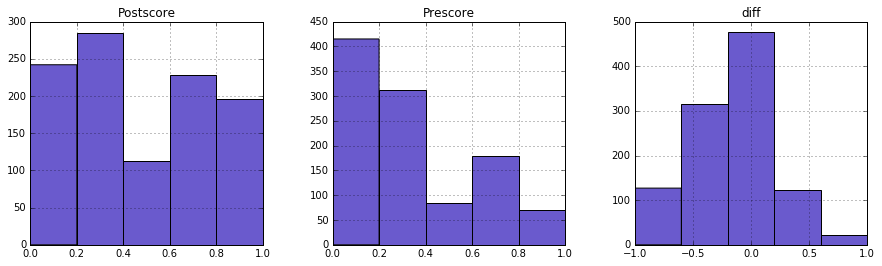

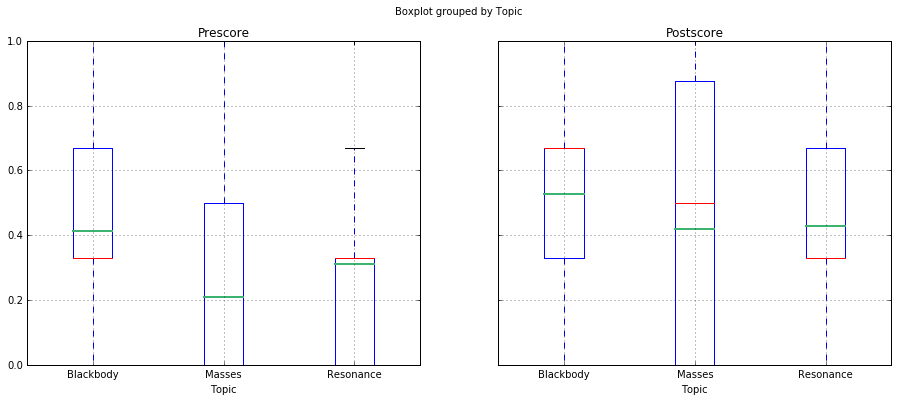

In [90]:
df_score['diff'] = df['Prescore']-df['Postscore']
df_score.hist(column=['Prescore','Postscore','diff'],bins=5, layout=(1,3),figsize=(15,4),color='slateblue')
meanlineprops = dict(linestyle='-', linewidth=2, color='mediumseagreen')
df.boxplot(by='Topic',
                column=['Prescore','Postscore'],
                figsize=(15,6),
                meanprops=meanlineprops, meanline=True, showmeans=True)

We can see from the histograms that we a wide spectrum of knowledge levels. The boxplots confirm that the student did indeed learn, as post-scores increased for all topics though in varying amounts per topic. We do a Mann-Whitney test (the equivalent a simple t-test for non normal data) to find out if the difference in score is significant.

In [76]:
from scipy.stats import mannwhitneyu
m = mannwhitneyu(df_score[df_score['Topic']=='Masses']['Prescore'],df_score[df_score['Topic']=='Masses']['Postscore'])
r = mannwhitneyu(df_score[df_score['Topic']=='Resonance']['Prescore'],df_score[df_score['Topic']=='Resonance']['Postscore'])
b = mannwhitneyu(df_score[df_score['Topic']=='Blackbody']['Prescore'],df_score[df_score['Topic']=='Blackbody']['Postscore'])
print("The significance of the post score difference is:\n{0} for Masses, \n{1} for Resonance, \n{2} for Blackbody".format(m,r,b))

The significance of the post score difference is:
MannwhitneyuResult(statistic=37082.5, pvalue=6.5778029651621694e-14) for Masses, 
MannwhitneyuResult(statistic=45640.5, pvalue=1.5005392378609296e-07) for Resonance, 
MannwhitneyuResult(statistic=61780.0, pvalue=8.8689502032254699e-08) for Blackbody


In [77]:
m = scipy.stats.wilcoxon(df_score[df_score['Topic']=='Masses']['Prescore'],df_score[df_score['Topic']=='Masses']['Postscore'])
r = scipy.stats.wilcoxon(df_score[df_score['Topic']=='Resonance']['Prescore'],df_score[df_score['Topic']=='Resonance']['Postscore'])
b = scipy.stats.wilcoxon(df_score[df_score['Topic']=='Blackbody']['Prescore'],df_score[df_score['Topic']=='Blackbody']['Postscore'])
print("The significance of the post score difference is:\n{0} for Masses, \n{1} for Resonance, \n{2} for Blackbody".format(m,r,b))

The significance of the post score difference is:
WilcoxonResult(statistic=1674.5, pvalue=3.737850387280999e-17) for Masses, 
WilcoxonResult(statistic=6157.5, pvalue=7.1031929202349846e-09) for Resonance, 
WilcoxonResult(statistic=6276.0, pvalue=8.2879438215317674e-10) for Blackbody


In [79]:
df_score[df_score['Topic']=='Masses'].describe()

,Prescore,Postscore,Clickerscore
count,327.000000,327.000000,327.000000
mean,0.206422,0.429664,0.789755
std,0.314850,0.398934,0.249897
min,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.750000
50%,0.000000,0.500000,0.750000
75%,0.500000,1.000000,1.000000
max,1.000000,1.000000,1.000000


In [80]:
df_score[df_score['Topic']=='Resonance'].describe()

,Prescore,Postscore,Clickerscore
count,342.000000,342.000000,342.000000
mean,0.308129,0.435117,0.366959
std,0.283272,0.319250,0.256315
min,0.000000,0.000000,0.000000
25%,0.000000,0.330000,0.330000
50%,0.330000,0.330000,0.330000
75%,0.330000,0.670000,0.670000
max,1.000000,1.000000,1.000000


## How much were they engaged in the activity?
#### Next we look at the time spent on task. Next let's look at how much time they spent on each activity.

In [81]:
df_score[df_score['Topic']=='Blackbody'].describe()

,Prescore,Postscore,Clickerscore
count,395.000000,395.000000,395.000000
mean,0.416481,0.531646,0.678759
std,0.287378,0.294774,0.255734
min,0.000000,0.000000,0.000000
25%,0.330000,0.330000,0.670000
50%,0.330000,0.670000,0.670000
75%,0.670000,0.670000,1.000000
max,1.000000,1.000000,1.000000


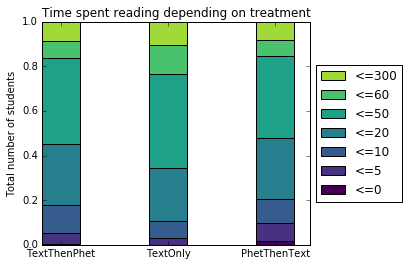

In [48]:
maxtime = int(np.max(df['Time on text']))
slices = [0,5,10,20,50,60,maxtime]

def calculate_totals(time,treatment):
    return sum(df[df['Treatment']==treatment]['Time on text']<=time)/float(sum(df[df['Treatment']==treatment]['Time on text']<=1000))

ind = np.arange(len(treatments))# the x locations for the groups
width = 0.35                    # the width of the bars: can also be len(x) sequence
cmap = matplotlib.cm.get_cmap('viridis')

ax = plt.subplot(111)
plt.bar(ind, [calculate_totals(slices[-1],t) for t in treatments], width, color=cmap((len(slices)-1)/float(len(slices))))
for i in reversed(range(len(slices)-1)):
    plt.bar(ind, [calculate_totals(slices[i],t) for t in treatments], 
            width, #bottom= [calculate_totals(slices[i],t) for t in treatments],
            color=cmap((i)/float(len(slices))))
plt.ylabel('Total number of students')
plt.title('Time spent reading depending on treatment')
plt.xticks(ind + width/2., treatments)
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
# Put a legend below current axis
ax.legend(['<='+str(slices[i]) for i in reversed(range(len(slices)))],loc='center left', bbox_to_anchor=(1, 0.5))

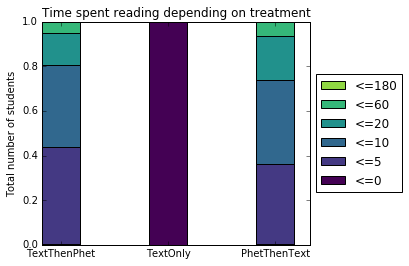

In [49]:
maxtime = int(np.max(df['Time on PhET']))
slices = [0,5,10,20,60,maxtime]

def calculate_totals(time,treatment):
    return sum(df[df['Treatment']==treatment]['Time on PhET']<=time)/float(sum(df[df['Treatment']==treatment]['Time on PhET']<=1000))

ind = np.arange(len(treatments))# the x locations for the groups
width = 0.35                    # the width of the bars: can also be len(x) sequence
cmap = matplotlib.cm.get_cmap('viridis')

ax = plt.subplot(111)
plt.bar(ind, [calculate_totals(slices[-1],t) for t in treatments], width, color=cmap((len(slices)-1)/float(len(slices))))
for i in reversed(range(len(slices)-1)):
    plt.bar(ind, [calculate_totals(slices[i],t) for t in treatments], 
            width, #bottom= [calculate_totals(slices[i],t) for t in treatments],
            color=cmap((i)/float(len(slices))))
plt.ylabel('Total number of students')
plt.title('Time spent reading depending on treatment')
plt.xticks(ind + width/2., treatments)
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
# Put a legend below current axis
ax.legend(['<='+str(slices[i]) for i in reversed(range(len(slices)))],loc='center left', bbox_to_anchor=(1, 0.5))

In [50]:
p = mannwhitneyu(df[df['Treatment']=='TextThenPhet']['Time on PhET'],df[df['Treatment']=='PhetThenText']['Time on PhET'])
t = mannwhitneyu(df[df['Treatment']=='TextThenPhet']['Time on text'],df[df['Treatment']=='PhetThenText']['Time on text'])
print("The significance of difference between time on task of conditions PhetThenText and TextThenPhet:\n{0} for Phet, \n{1} for text".format(p,t))

The significance of difference between time on task of conditions PhetThenText and TextThenPhet:
MannwhitneyuResult(statistic=104747.0, pvalue=0.98307411002794387) for Phet, 
MannwhitneyuResult(statistic=107757.0, pvalue=0.46439842056534641) for text


## Prior and knowledge and attitude influence on engagement
#### If they already encountered the topic were they more likely to score well on the pretest?

In [51]:
m0 = mannwhitneyu(df2[df2['Encountered']=='False']['Prescore'],df2[df2['Encountered']=='True']['Prescore'])
print("The significance of difference between having encountered the topic and on prescore {0}".format(m0))

The significance of difference between having encountered the topic and on prescore MannwhitneyuResult(statistic=30962.5, pvalue=0.0096002869873254102)


#### If they already encountered the topic were they more likely to be engaged?¶

In [52]:
p = mannwhitneyu(df[df['Encountered']=='True']['Time on PhET'],df[df['Encountered']=='False']['Time on PhET'])
t = mannwhitneyu(df[df['Encountered']=='True']['Time on text'],df[df['Encountered']=='False']['Time on text'])
print("The significance of difference between time on task of conditions depending on if they encountered the topic previously:\n{0} for Phet, \n{1} for text".format(p,t))

The significance of difference between time on task of conditions depending on if they encountered the topic previously:
MannwhitneyuResult(statistic=93191.0, pvalue=0.91992610482092085) for Phet, 
MannwhitneyuResult(statistic=99550.5, pvalue=0.064606164765661347) for text


#### If they enjoyed the activity, were they more likely to be engaged?
#### If they benefitted from the activity, were they more likely to be engaged?
#### *WARNING* - I don't think spearman is the appropriate measure... either way we may not need significance for these tests, only show the bar plots Jared already made.

In [53]:
convert = {"Not beneficial at all.":0,"Not very beneficial.":1,"Somewhat beneficial.":2,"Very beneficial.":3}
df2['Quantified benefitted'] = df2['Postattitude - benefitted'].apply(lambda x: convert[x])
convert = {"No enjoyment at all.":0,"Did not enjoy it very much.":1,"Somewhat enjoyed it.":2,"Enjoyed it very much.":3}
df2['Quantified enjoyed'] = df2['Postattitude - enjoyed'].apply(lambda x: convert[x])

s1 = scipy.stats.spearmanr(df2['Quantified benefitted'],df2['Time on PhET'])
s2 = scipy.stats.spearmanr(df2['Quantified enjoyed'],df2['Time on PhET'])
s3 = scipy.stats.spearmanr(df2['Quantified benefitted'],df2['Time on text'])
s4 = scipy.stats.spearmanr(df2['Quantified enjoyed'],df2['Time on text'])
print("The correlation between time spent doing the Phet and benifitted is: {0}\n".format(s1) +
      "The correlation between time spent doing the Phet and enjoyement is: {0}\n".format(s2) +
      "The correlation between time spent doing the reading and benefitted is: {0}\n".format(s3) +
      "The correlation between time spent doing the reading and enjoyement is: {0}\n".format(s4))

The correlation between time spent doing the Phet and benifitted is: SpearmanrResult(correlation=0.030861294060812519, pvalue=0.47792527611114555)
The correlation between time spent doing the Phet and enjoyement is: SpearmanrResult(correlation=0.035616517502192864, pvalue=0.4127563211784655)
The correlation between time spent doing the reading and benefitted is: SpearmanrResult(correlation=-0.036957576608362672, pvalue=0.39537344522680362)
The correlation between time spent doing the reading and enjoyement is: SpearmanrResult(correlation=-0.067678409857134733, pvalue=0.11931522080970305)



C:\Users\Sarah\Anaconda2\lib\site-packages\ipykernel\__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
C:\Users\Sarah\Anaconda2\lib\site-packages\ipykernel\__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


# Performance analysis by engagement
## Visual investigation of effect of engagement

In [54]:
##show line plots with x = pre to post, colored by condition, grouped by engagement level
##SORRY! I didn't have time to tackle this piece...

## Postscore analysis with engagement * condition interaction term
#### Next let's group by engagement and see if there is a different in performance.


In [55]:
import statsmodels.formula.api as smf
import statsmodels.api as sm

formula = '''df2["Postscore"] ~ df2["Reading group"] + 
            df2["Prescore"] + df2["Topic"] +
            df2["Treatment"]*df2["Time on text"]*df2["Time on PhET"]'''
glm_f_binom = smf.glm(formula = formula, data = df2.dropna(),  family=sm.families.Binomial())
res = glm_f_binom.fit()
print(res.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:       df2["Postscore"]   No. Observations:                  531
Model:                            GLM   Df Residuals:                      517
Model Family:                Binomial   Df Model:                           13
Link Function:                  logit   Scale:                             1.0
Method:                          IRLS   Log-Likelihood:                -342.04
Date:                Tue, 31 May 2016   Deviance:                       630.74
Time:                        12:52:39   Pearson chi2:                     262.
No. Iterations:                     7                                         
                                                                               coef    std err          z      P>|z|      [95.0% Conf. Int.]
--------------------------------------------------------------------------------------------------------------------------------------------
Interce

In [56]:
phet_median = df2[df2['Treatment']!='TextOnly']['Time on PhET'].median()
df2['Engaged PhET'] = df2[df2['Treatment']!='TextOnly']['Time on PhET'] >= phet_median
text_median = df2['Time on text'].median()
df2['Engaged text'] = df2['Time on text'] >= text_median
'The median engagment times for PhET and text are {0} and {1} minutes.'.format(phet_median,text_median)

C:\Users\Sarah\Anaconda2\lib\site-packages\ipykernel\__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
C:\Users\Sarah\Anaconda2\lib\site-packages\ipykernel\__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


'The median engagment times for PhET and text are 8.0 and 30.0 minutes.'

In [83]:
import statsmodels.formula.api as smf
import statsmodels.api as sm

formula = '''df_score["Postscore"] ~ df_score["Prescore"] + df_score["Topic"]*df_score["Treatment"]'''
glm_f_binom = smf.glm(formula = formula, data = df_score,  family=sm.families.Binomial())
res = glm_f_binom.fit()
print(res.summary())

                   Generalized Linear Model Regression Results                   
Dep. Variable:     df_score["Postscore"]   No. Observations:                 1064
Model:                               GLM   Df Residuals:                     1054
Model Family:                   Binomial   Df Model:                            9
Link Function:                     logit   Scale:                             1.0
Method:                             IRLS   Log-Likelihood:                -696.56
Date:                   Tue, 31 May 2016   Deviance:                       1367.1
Time:                           13:22:07   Pearson chi2:                     455.
No. Iterations:                        7                                         
                                                                           coef    std err          z      P>|z|      [95.0% Conf. Int.]
-----------------------------------------------------------------------------------------------------------------------------

## Clickerscore analysis with engagement * condition interaction term

In [84]:
formula = '''df_score["Clickerscore"] ~ df_score["Prescore"] + df_score["Topic"]*df_score["Treatment"]'''
glm_f_binom = smf.glm(formula = formula, data = df_score,  family=sm.families.Binomial())
res = glm_f_binom.fit()
print(res.summary())

                    Generalized Linear Model Regression Results                     
Dep. Variable:     df_score["Clickerscore"]   No. Observations:                 1064
Model:                                  GLM   Df Residuals:                     1054
Model Family:                      Binomial   Df Model:                            9
Link Function:                        logit   Scale:                             1.0
Method:                                IRLS   Log-Likelihood:                -636.01
Date:                      Tue, 31 May 2016   Deviance:                       1642.7
Time:                              13:23:25   Pearson chi2:                     328.
No. Iterations:                           7                                         
                                                                           coef    std err          z      P>|z|      [95.0% Conf. Int.]
--------------------------------------------------------------------------------------------------

In [85]:
formula = '''df_score["Clickerscore"] ~ df_score["Prescore"]*df_score["Postscore"] + df_score["Topic"]*df_score["Treatment"]'''
glm_f_binom = smf.glm(formula = formula, data = df_score,  family=sm.families.Binomial())
res = glm_f_binom.fit()
print(res.summary())

                    Generalized Linear Model Regression Results                     
Dep. Variable:     df_score["Clickerscore"]   No. Observations:                 1064
Model:                                  GLM   Df Residuals:                     1052
Model Family:                      Binomial   Df Model:                           11
Link Function:                        logit   Scale:                             1.0
Method:                                IRLS   Log-Likelihood:                -631.66
Date:                      Tue, 31 May 2016   Deviance:                       1635.2
Time:                              13:26:55   Pearson chi2:                     321.
No. Iterations:                           7                                         
                                                                           coef    std err          z      P>|z|      [95.0% Conf. Int.]
--------------------------------------------------------------------------------------------------

#### Interestingly, low or no effect by the prescore on the clickerscore... Treatment marginally mattered, engagement didn't.

## Reading assignment and preparedness: what's the difference between the clicker and postscore?
#### To see if the reading material was sufficient to prepare students for class, let's so how differently they performed on the clicker versus post reading quiz.


In [59]:
formula = '''df2["Clickerscore"] ~ df2["Reading group"] + 
            df2["Prescore"] + df2["Postscore"] + df2["Topic"] +
            df2["Treatment"]*df2["Engaged PhET"]*df2["Engaged text"]'''
glm_f_binom = smf.glm(formula = formula, data = df2,  family=sm.families.Binomial())
res = glm_f_binom.fit()
print(res.summary())

                  Generalized Linear Model Regression Results                  
Dep. Variable:     df2["Clickerscore"]   No. Observations:                  355
Model:                             GLM   Df Residuals:                      343
Model Family:                 Binomial   Df Model:                           11
Link Function:                   logit   Scale:                             1.0
Method:                           IRLS   Log-Likelihood:                -207.80
Date:                 Tue, 31 May 2016   Deviance:                       460.51
Time:                         12:52:39   Pearson chi2:                     108.
No. Iterations:                      7                                         
                                                                                               coef    std err          z      P>|z|      [95.0% Conf. Int.]
---------------------------------------------------------------------------------------------------------------------------

#### Postscore had an increasing effect on clickerscore. Apparently, students did really poorly on the Resonance clicker questions (or maybe on question in particular?)